# PS4E8 : **Binary Prediction of Poisonous Mushrooms**

## >> **USE AUTO-ML (PYCARET)**

## 00. **SET WORK ENVORINMENT**

#### 00.1. **DEFINE PRE-VARIABELS**

In [1]:
seed_num = 2024
compet_nm = 'PS4E8'

#### 00.2. **IMPORT PACKAGES AND SET OPTIONS**

In [2]:
#(1) Import packages
import os
import logging
import shutil
import warnings
import re
import numpy as np
from scipy.stats import boxcox
import pandas as pd
import tabulate
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
# import lightgbm 
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from pycaret import classification as pycrt_clf

#(2) Set system options
logging.getLogger(name='pycaret').addHandler(hdlr=logging.NullHandler())
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(precision=3, suppress=True)
tabulate.WIDE_CHARS_MODE = False
# plt.rcParams["font.family"] = 'D2Coding'

#### 00.3. **CREATE USER-DEFINED FUNCTION**

In [3]:
#(1) Create `diagnose_df()` function
def diagnose_df(df:pd.DataFrame) -> pd.DataFrame : 
    output = pd.DataFrame(data=df.dtypes).reset_index()
    output.columns = ['COLUMN_NM', 'DATA_TYPE']
    output.loc[:, 'ROW_CNT'] = len(df)
    output.loc[:, 'NA_CNT'] = df.isna().sum().values
    output.loc[:, 'NA_RATE'] = output.loc[:, 'NA_CNT'] / output.loc[:, 'ROW_CNT']
    output.loc[:, 'UNIQUE_CNT'] = df.nunique().values
    output.loc[:, 'UNIQUE_RATE'] = output.loc[:, 'UNIQUE_CNT'] / output.loc[:, 'ROW_CNT']
    return output

#(2) Create `diagnose_num_df()` function
def diagnose_num_df(df:pd.DataFrame) -> pd.DataFrame : 
    df = df.select_dtypes(include='number')
    output = df.describe(include='all', percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()
    output.loc[:, 'median'] = df.median()
    output.loc[:, 'mode'] = df.mode().values[0]
    output = relocate_col(df=output, tar_col='median', std_col='mean', how='after')
    output = relocate_col(df=output, tar_col='mode', std_col='median', how='after')
    output.columns = np.array(object=list(map(np.char.upper, output.columns)))
    output = output.rename(columns={'COUNT' : 'ROW_CNT'})
    output['ROW_CNT'] = output['ROW_CNT'].astype(dtype='int')
    return output

#(3) Create `relocate_col()` function
def relocate_col(df:pd.DataFrame, tar_col:str, std_col:str, how:str='after') -> pd.DataFrame : 
    col_ary = np.array(object=df.columns)
    tar_col_idx = np.where(col_ary==tar_col)[0][0]
    std_col_idx = np.where(col_ary==std_col)[0][0]
    col_ary = np.delete(arr=col_ary, obj=tar_col_idx)
    if how == 'after' : 
        if std_col_idx == len(col_ary) : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col)
        else :
            col_ary = np.insert(arr=col_ary, obj=std_col_idx+1, values=tar_col)
    elif how == 'before' : 
        if std_col_idx == 0 : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col) 
        else : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx-1, values=tar_col)
    else : 
        pass
    output = df.loc[:, col_ary]
    return output 

#(4) Create `summary_cat_cols()` function
def summary_cat_cols(df:pd.DataFrame, pick_col:str, markdown_yn:str='y') -> pd.DataFrame :
    counts = df.loc[:, pick_col].astype(dtype='str').value_counts()
    percentages = (counts / len(df) * 100).round(decimals=2)
    output = pd.DataFrame(data={
        'COL_NM'    : pick_col,
        'VALUE'     : counts.index,
        'CNT'       : counts.values,
        'PERCENTAGE': percentages.values
    })
    CON = (output.loc[:, 'COL_NM'] == pick_col)
    output = output.loc[CON, :]
    if markdown_yn == 'y' :
        output = output.to_markdown(tablefmt='simple_grid', floatfmt='.2f')
    return output

#(5) Create `draw_hist()` function
def draw_hist(df:pd.DataFrame) -> plt.plot :
    num_cols = df.select_dtypes(include=['number']).columns
    col_size = 3
    row_size = (len(num_cols) + col_size - 1) // col_size
    fig, axes = plt.subplots(nrows=row_size, ncols=col_size, figsize=(18, 5 * row_size))
    fig.suptitle(t='Distribution of Numerical Features', fontweight='bold', fontsize=16)
    axes = axes.flatten()
    for i, col in enumerate(num_cols):
        sns.histplot(data=df.loc[:, col], kde=True, ax=axes[i], color='skyblue', element='step', stat='density')
        axes[i].set_title(label=f'Distribution of `{col}`', fontsize=14)
        axes[i].set_xlabel(xlabel=col, fontsize=12)
        axes[i].set_ylabel(ylabel='Density', fontsize=12)
        axes[i].grid(visible=False)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

#(6) Create `clean_val()` function
def clean_val(value:str) -> str :
    value = re.sub(pattern=r'(\d+\s|x\s|is\s|does\s|has\s|has-|\s+has-ring)', repl='', string=value)
    return value

#(7) Create `replace_non_alphabetical()` function
def replace_non_alphabetical(value:str) -> vars :
    if isinstance(value, str) and (len(value) == 1 and value.isalpha()):
        return value
    return np.nan

#(8) Create `replace_cat_val()` function
def replace_cat_val(df:pd.DataFrame) -> pd.DataFrame :
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df.loc[:, col] = df.loc[:, col].astype(dtype='str').apply(func=clean_val)
        df.loc[:, col] = df.loc[:, col].apply(func=replace_non_alphabetical)
    return df

#(8) Create `handle_cat_na()` function
def handle_cat_na(df:pd.DataFrame, method:str='mode') -> pd.DataFrame :
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df.loc[:, col].isnull().any():
            if method == 'mode':
                mode_value = df.loc[:, col].mode()[0] if not df.loc[:, col].mode().empty else 'Unknown'  # Safe mode handling
                df.loc[:, col].fillna(value=mode_value, inplace=True)
            # elif method == 'class_mode':
            #     mode_values = df.groupby('class')[col].apply(func=(lambda x: x.mode().get(key=0, default='Unknown')))
            #     for group in mode_values.index:
            #         CON = (df['class'] == group) & (df.loc[:, col].isnull())
            #         df.loc[CON, col] = mode_values[group]
            elif method == 'knn':
                # KNN을 사용하여 결측치를 처리할 구현 필요
                pass
            elif method == 'unknown':
                mode_value = 'unknown'
                df.loc[:, col].fillna(value=mode_value, inplace=True)

    return df

#(9) Create `handle_num_na()` function
def handle_num_na(df:pd.DataFrame, method:str='mode') -> pd.DataFrame :
    num_cols = df.select_dtypes(include=['number']).columns
    if method == 'mode' :
        for col in num_cols:
            if df.loc[:, col].isnull().any():
                median_value = df.loc[:, col].median()
                df.loc[:, col] = df.loc[:, col].fillna(value=median_value)
    elif method == 'knn' : 
        imputer = KNNImputer(n_neighbors=5)
        df.loc[:, num_cols] = imputer.fit_transform(X=df.loc[:, num_cols])
        pass
    return df

#(10) Create `handle_skewness()` function
def handle_skewness(df:pd.DataFrame, threshold:int=1.0) -> tuple :
    num_cols = df.select_dtypes(include=['number']).columns
    lambda_dict = {}
    for col in num_cols:
        skewness = df.loc[:, col].skew()
        if skewness > threshold :
            df.loc[:, col] = df.loc[:, col] + 1 #
            df.loc[:, col], fitted_lambda = boxcox(x=df.loc[:, col])
            lambda_dict[col] = fitted_lambda
    return df, lambda_dict

#(11) Create `apply_skewness()` function
def apply_skewness(df:pd.DataFrame, lambda_dict:dict) -> pd.DataFrame :
    for col, lam in lambda_dict.items() :
        df.loc[:, col] = df.loc[:, col] + 1
        df.loc[:, col] = boxcox(x=df.loc[:, col], lmbda=lam)
    return df

#(12) Create `handle_outliers()` function
def handle_outliers(df:pd.DataFrame) -> pd.DataFrame :
    num_cols = df.select_dtypes(include=['number']).columns
    for col in num_cols :
        Q1 = df.loc[:, col].quantile(0.25)
        Q3 = df.loc[:, col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.25 * IQR
        upper_bound = Q3 + 1.25 * IQR
        df.loc[:, col] = df.loc[:, col].clip(lower=lower_bound, upper=upper_bound)
    return df

<b></b>

## 01. **READ AND CONCATENATE**

##### 01.1. **READ DATASETS**

In [4]:
#(1) Define file-path
file_path = f'{os.getcwd()}/../data/{compet_nm}'

#(2) Read Datasets
train_ori_raw = pd.read_table(filepath_or_buffer=f'{file_path}/train.csv', sep=',')
train_sub_raw = pd.read_table(filepath_or_buffer=f'{file_path}/train_sub.csv', sep=';')
test_raw = pd.read_table(filepath_or_buffer=f'{file_path}/test.csv', sep=',')

##### 01.2. **CONCATENATE DATASETS**

In [5]:
#(1) Print shapes of train datasets
print(f'>> Original train dataset shape : {train_ori_raw.shape}')
print(f'>> Secondary(sub) train dataset shape : {train_sub_raw.shape}')

>> Original train dataset shape : (3116945, 22)
>> Secondary(sub) train dataset shape : (61069, 21)


In [6]:
#(3) Concat datasets
train_raw = pd.concat(objs=[train_ori_raw, train_sub_raw], axis=0)

#(4) Drop duplicated values
# train_raw = train_raw.drop(labels=['veil-type'], axis=1)
train_raw = train_raw.drop_duplicates(subset=train_raw.columns.to_list().remove('class'), keep='first')
train_raw = train_raw.reset_index(drop=True)

#(5) Print `train_raw`
train_raw

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0.0000,e,8.8000,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1.0000,p,4.5100,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2.0000,e,6.9400,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.0000,e,3.8800,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4.0000,e,5.8500,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177863,NaN,p,1.1800,s,s,y,f,f,f,f,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
3177864,NaN,p,1.2700,f,s,y,f,f,f,f,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
3177865,NaN,p,1.2700,s,s,y,f,f,f,f,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
3177866,NaN,p,1.2400,f,s,y,f,f,f,f,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


<b></b>

## 02. **EDA**

#### 02.1. **CHECK DATASET SHAPE**

In [7]:
print(f'>> Train raw dataset shape : {train_raw.shape}')
print(f'>> Test raw dataset shape : {test_raw.shape}')

>> Train raw dataset shape : (3177868, 22)
>> Test raw dataset shape : (2077964, 21)


#### 02.2. **DEFINE COLUMNS**

reference : [UCI Mushroom dataset](https://archive.ics.uci.edu/dataset/73/mushroom)

| Role | Name | Description | Values |
|-|-|-|-|
| index | `id` | 식별값 | |
| target | `class` | 독성 및 식용 여부 | `p`(poisonous) / `e`(edible) |
| feature | `cap-diameter` | 모자 지름 | `cm`(unit) |
| feature | `cap-shape` | 모자 형태 | `b`(bell) / `c`(conical) / `x`(convex) / `f`(flat) / `k`(knobbed) / `s`(sunken) |
| feature | `cap-surface` | 모자 표면 특성 | `f`(fibrous) / `g`(grooves) / `y`(scaly) / `s`(smooth) |
| feature | `cap-color` | 모자 색상 | `n`(brown) / `b`(buff) / `c`(cinnamon) / `g`(gray) / `r`(green) / `p`(pink) / `u`(purple) / `e`(red) / `w`(white) / `y`(yellow) |
| feature | `does-bruise-or-bleed` | 멍 / 즙 발생 여부 | `t`(True) / `f`(False) |
| feature | `gill-attachment` | 아가미 부착 여부 | `a`(attached) / `d`(descending) / `f`(free) / `n`(notched) |
| feature | `gill-spacing` | 아가미 간의 간격 | `c`(close) / `w`(crowded) / `d`(distant) |
| feature | `gill-color` | 아가미 색상 | `k`(black) / `n`(brown) / `b`(buff) / `h`(chocolate) / `g`(gray) / `r`(green) / `o`(orange) / `p`(pink) / `u`(purple) / `e`(red) / `w`(white) / `y`(yellow) |
| feature | `stem-height` | 줄기 높이 | `cm`(unit) |
| feature | `stem-width` | 줄기 너비 | `mm`(unit) |
| feature | `stem-surface` | 줄기 표면 특성 | `i`(fibrous) / `g`(grooves) / `y`(scaly) / `s`(smooth) / `h`(shiny) / `l`(leathery) / `k`(silky) / `t`(sticky) / `w`(wrinkled) / `e`(fleshy) |
| feature | `stem-color` | 줄기 색상 | `n`(brown) / `b`(buff) / `c`(cinnamon) / `g`(gray) / `r`(green) / `p`(pink) / `u`(purple) / `e`(red) / `w`(white) / `y`(yellow) / `f`(none) |
| feature | `veil-type` | 베일 표면 특성 | `p`(partial) / `u`(universal) |
| feature | `veil-color` | 베일 색상 | `n`(brown) / `b`(buff) / `c`(cinnamon) / `g`(gray) / `r`(green) / `p`(pink) / `u`(purple) / `e`(red) / `w`(white) / `y`(yellow) / `f`(none) |
| feature | `has-ring` | 고리 존재 여부 | `t`(True) / `f`(False) |
| feature | `ring-type` | 고리 유형 | `c`(cobwebby) / `e`(evanescent) / `r`(flaring) / `g`(grooved) / `l`(large) / `p`(pendant) / `s`(sheathing) / `z`(zone) / `y`(scaly) / `m`(movable) / `f`(none) / $ \cdots{} $ |
| feature | `spore-print-color` | 포자 프린트 색상 | `n`(brown) / `b`(buff) / `c`(cinnamon) / `g`(gray) / `r`(green) / `p`(pink) / `u`(purple) / `e`(red) / `w`(white) / `y`(yellow) |
| feature | `habitat` | 자라는 환경 | `g`(grasses) / `l`(leaves) / `m`(meadows) / `p`(paths) / `h`(heaths) / `u`(urban) / `w`(waste) / `d`(woods) |
| feature | `season` | 발견되는 계절 | `s`(spring) / `u`(summer) / `a`(autumn) / `w`(winter) |


#### 02.3. **DIAGNOSE TRAIN DATASET**

##### 02.3.1. **CHECK `ALL` VALUES**

In [8]:
#(1) Diagnose `train_raw`
diag_train = diagnose_df(df=train_raw)

#(2) Print `diag_train`
diag_train

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,id,float64,3177868,60923,0.0192,3116945,0.9808
1,class,object,3177868,0,0.0000,2,0.0000
2,cap-diameter,float64,3177868,4,0.0000,3914,0.0012
3,cap-shape,object,3177868,40,0.0000,74,0.0000
4,cap-surface,object,3177868,685143,0.2156,83,0.0000
5,cap-color,object,3177868,12,0.0000,78,0.0000
6,does-bruise-or-bleed,object,3177868,8,0.0000,26,0.0000
7,gill-attachment,object,3177868,533791,0.1680,78,0.0000
8,gill-spacing,object,3177868,1283497,0.4039,48,0.0000
9,gill-color,object,3177868,57,0.0000,63,0.0000


##### 02.3.2. **CHECK `NA` VALUES**

- `stem-root`, `veil-type`, `veil-color`, `spore-print-color` : 결측값 비율 $ 80 \% $ 이상인 열 $ \rightarrow{} $ 삭제

In [9]:
CON = (diag_train.loc[:, 'NA_RATE'] >= 0.8)
diag_train.loc[CON, :]

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
12,stem-root,object,3177868,2808559,0.8838,38,0.0000
15,veil-type,object,3177868,3015239,0.9488,22,0.0000
16,veil-color,object,3177868,2794457,0.8793,24,0.0000
19,spore-print-color,object,3177868,2904279,0.9139,32,0.0000


##### 02.3.3. **CHECK `NUMERICAL` VALUEES** (DESCRIPTIVE STATISTICS)

- `cap-diameter` : 비교적 평균-중앙값 비슷(대칭적인 분포) / 이상치 존재 (ex $ 80.67 $)

- `stem-height` : 비교적 평균-중앙값 비슷(대칭적인 분포) / 이상치 존재 (ex $ 0 ,\, 88.72 $)

- `stem-width` : 표준편차가 큼(분포가 넓음) / 이상치 존재 (ex $ 0 ,\, 103.91 $)

In [10]:
#(1) Check numerical columns (descriptive statistics)
num_cols = train_raw.select_dtypes(include=['float', 'int']).columns.drop(labels='id')

#(2)
diagnose_num_df(df=train_raw.loc[:, num_cols])

,ROW_CNT,MEAN,MEDIAN,MODE,STD,MIN,1%,10%,25%,50%,75%,90%,99%,MAX
cap-diameter,3177864,6.3181,5.7500,1.4900,4.6708,0.0300,0.7400,1.6900,3.3200,5.7500,8.2500,11.0200,18.9300,80.6700
stem-height,3177868,6.3531,5.8800,5.2400,2.7141,0.0000,2.1800,3.6100,4.6700,5.8800,7.4100,9.6100,16.7200,88.7200
stem-width,3177868,11.1734,9.6600,2.4100,8.1381,0.0000,0.9600,2.4700,4.9800,9.6600,15.6500,22.5400,35.6400,103.9100


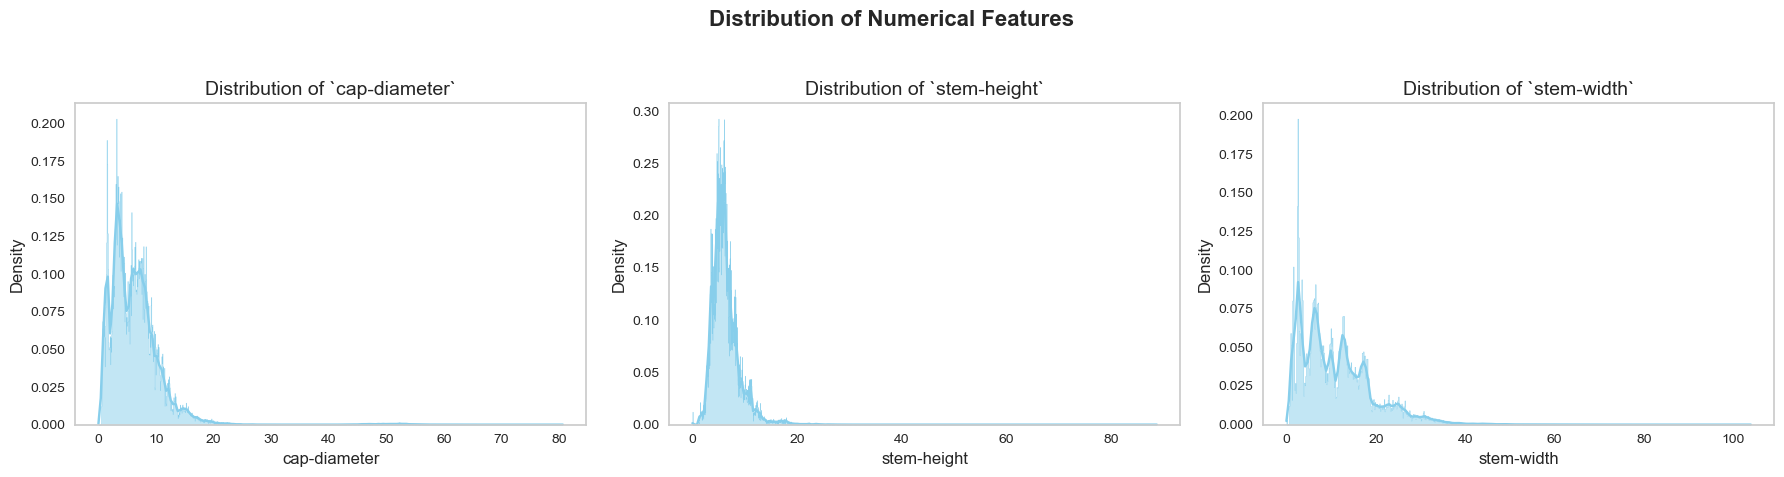

In [11]:
#(3) Draw histogram
draw_hist(df=train_raw.loc[:, num_cols])

##### 02.3.4. **CHECK `CATEGORICAL` VALUES**

In [12]:
#(2) Print all categorical values of train dataset
cat_cols = train_raw.select_dtypes(include=['object']).columns
for col in cat_cols :
    print(f'>> Check Category Value : "{col}" COLUMN')
    print(summary_cat_cols(df=train_raw, pick_col=col, markdown_yn='y'))
    print(' ')

>> Check Category Value : "class" COLUMN
┌────┬──────────┬─────────┬─────────┬──────────────┐
│    │ COL_NM   │ VALUE   │     CNT │   PERCENTAGE │
├────┼──────────┼─────────┼─────────┼──────────────┤
│  0 │ class    │ p       │ 1739138 │        54.73 │
├────┼──────────┼─────────┼─────────┼──────────────┤
│  1 │ class    │ e       │ 1438730 │        45.27 │
└────┴──────────┴─────────┴─────────┴──────────────┘
 
>> Check Category Value : "cap-shape" COLUMN
┌────┬───────────┬───────────┬─────────┬──────────────┐
│    │ COL_NM    │ VALUE     │     CNT │   PERCENTAGE │
├────┼───────────┼───────────┼─────────┼──────────────┤
│  0 │ cap-shape │ x         │ 1462958 │        46.04 │
├────┼───────────┼───────────┼─────────┼──────────────┤
│  1 │ cap-shape │ f         │  689642 │        21.70 │
├────┼───────────┼───────────┼─────────┼──────────────┤
│  2 │ cap-shape │ s         │  372310 │        11.72 │
├────┼───────────┼───────────┼─────────┼──────────────┤
│  3 │ cap-shape │ b         │  32434

<b></b>

## 03. **PREPROCESS**

##### 03.0. **COPY DATASETS**

In [13]:
train = train_raw.copy()
test = test_raw.copy()

#### 03.1. **CLEAN CATEGORICAL VALUES**

##### 03.1.1. **REPLACE OUTLIERS**

- `[0-9]{1,} + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `is + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `does + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `has + \s + [a-zA-z]{1}` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

- `[a-zA-z]{1} + \s + has-ring` $ \, \rightarrow{} $ `[a-zA-z]{1}` 처리

-  `[0-9]{1, }` $ \, \rightarrow{} $ `NA` 처리

-  `[a-zA-z]{2, }` (character length가 $ \, 2 $ 이상인 경우) $ \, \rightarrow{} $ `NA` 처리

In [14]:
#(1)
train = replace_cat_val(df=train)
test = replace_cat_val(df=test)

#(2)
# for col in cat_cols :
#     print(f'>> Check Category Value : "{col}" COLUMN')
#     print(summary_cat_cols(df=train, pick_col=col, markdown_yn='y'))
#     print(' ')

##### 03.1.2. **REPLACE `NA`**

In [15]:
#(1)
train = handle_cat_na(df=train, method='unknown')
test = handle_cat_na(df=test, method='unknown')

#(2)
for col in cat_cols :
    print(f'>> Check Category Value : "{col}" COLUMN')
    print(summary_cat_cols(df=train, pick_col=col, markdown_yn='y'))
    print(' ')

>> Check Category Value : "class" COLUMN
┌────┬──────────┬─────────┬─────────┬──────────────┐
│    │ COL_NM   │ VALUE   │     CNT │   PERCENTAGE │
├────┼──────────┼─────────┼─────────┼──────────────┤
│  0 │ class    │ p       │ 1739138 │        54.73 │
├────┼──────────┼─────────┼─────────┼──────────────┤
│  1 │ class    │ e       │ 1438730 │        45.27 │
└────┴──────────┴─────────┴─────────┴──────────────┘
 
>> Check Category Value : "cap-shape" COLUMN
┌────┬───────────┬─────────┬─────────┬──────────────┐
│    │ COL_NM    │ VALUE   │     CNT │   PERCENTAGE │
├────┼───────────┼─────────┼─────────┼──────────────┤
│  0 │ cap-shape │ x       │ 1462962 │        46.04 │
├────┼───────────┼─────────┼─────────┼──────────────┤
│  1 │ cap-shape │ f       │  689643 │        21.70 │
├────┼───────────┼─────────┼─────────┼──────────────┤
│  2 │ cap-shape │ s       │  372311 │        11.72 │
├────┼───────────┼─────────┼─────────┼──────────────┤
│  3 │ cap-shape │ b       │  324340 │        10.21 │
├

#### 03.2. **CLEAN NUMERICAL VALUES**

##### 03.2.1. **REPACE `NA` VALUE** (REPLACE MEDIAN)

In [16]:
train = handle_num_na(df=train)
test = handle_num_na(df=test)

##### 03.2.2. **ADJUST SKEWNESS** (BOX-COX TRANSFORMATION)

- Box-Cox 변환은 수치형 변수의 왜도(skewness)를 줄여 정규성(정규분포의 특징들과 유사해지는 정도)를 높임

- $ x(\lambda{}) = \begin{cases} \frac{x^\lambda{}-1}{\lambda{}} \;\;\;\;\;\;\;\;\;\; \lambda{} \neq{} 0 \\ \text{log}(x) \;\;\;\;\;\;\;\, \lambda{} = 0 \end{cases} \;\; $ where $ \, x > 0  $

$ \hspace{0.6cm} $($ \lambda{} $ 는 데이터가 가장 정규성을 잘 따르게 하는 값을 찾아서 사용)

- 변환을 통해 **분포의 정규성 향상 / 분산 안정화 / 이상치에 영향력 감소(=강건함?)** 효과를 얻음

**(PLUS)** 트리 기반 모델을 사용하더라도 수치형 변수에 대하여 정규성을 확보해야 하는 이유

$ \rightarrow{} $ 트리 모델은 특정 컬럼의 데이터를 탐색하며 불순도를 계산, 불순도가 가장 낮아지는 지점을 찾아 분할(decision boundary)을 진행함 

이 때 데이터가 심하게 치우쳐져 있으면 특정 층의 노드에 집중될 수 있어 일반화 및 효율적인 학습이 불가하기 때문

In [17]:
#(1) handle Skness
train, lambda_train = handle_skewness(df=train)

#(2) Print lambda of train
print(f'>> Train Lambda : {lambda_train}')

>> Train Lambda : {'cap-diameter': 0.06385469812937607, 'stem-height': -0.1270944837029198, 'stem-width': 0.20508540030467412}


In [18]:
#(3) Apply lambda 
test = apply_skewness(df=test, lambda_dict=lambda_train)

##### 03.2.2. **HANDLE OUTLIER** (IQR METHOD)

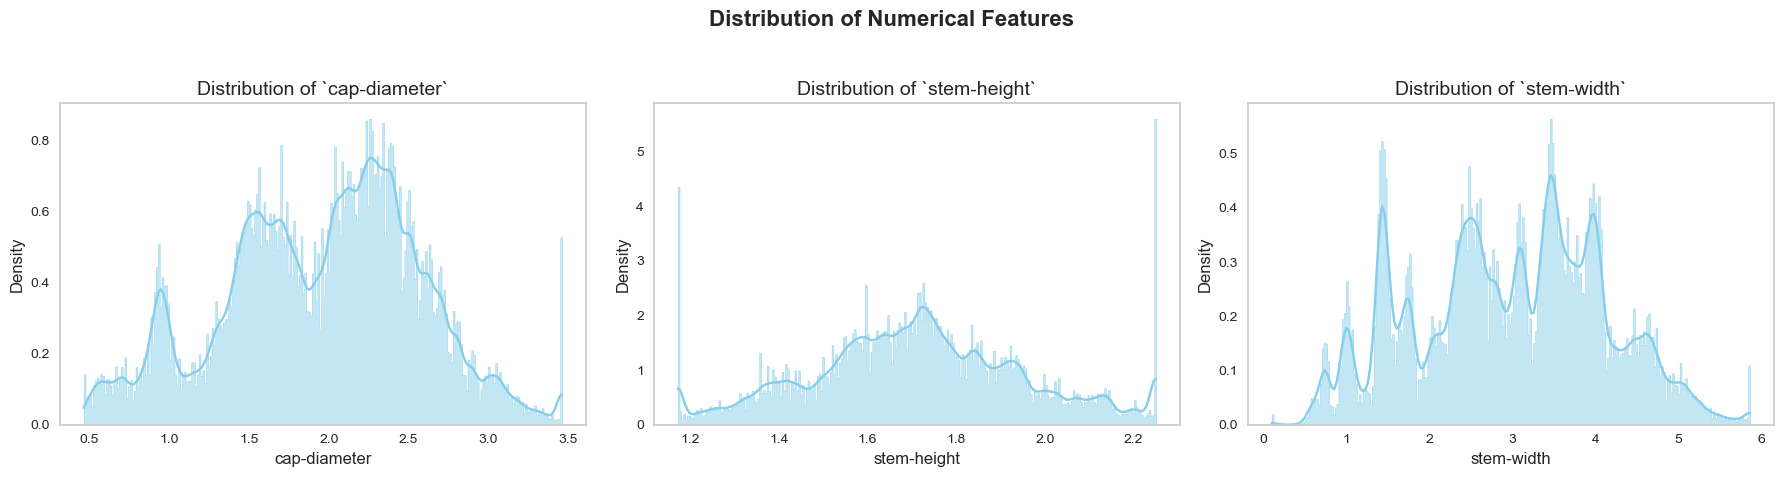

In [19]:
#(1)
train = handle_outliers(df=train)
test = handle_outliers(df=test)

#(2)
draw_hist(df=train.loc[:, num_cols])

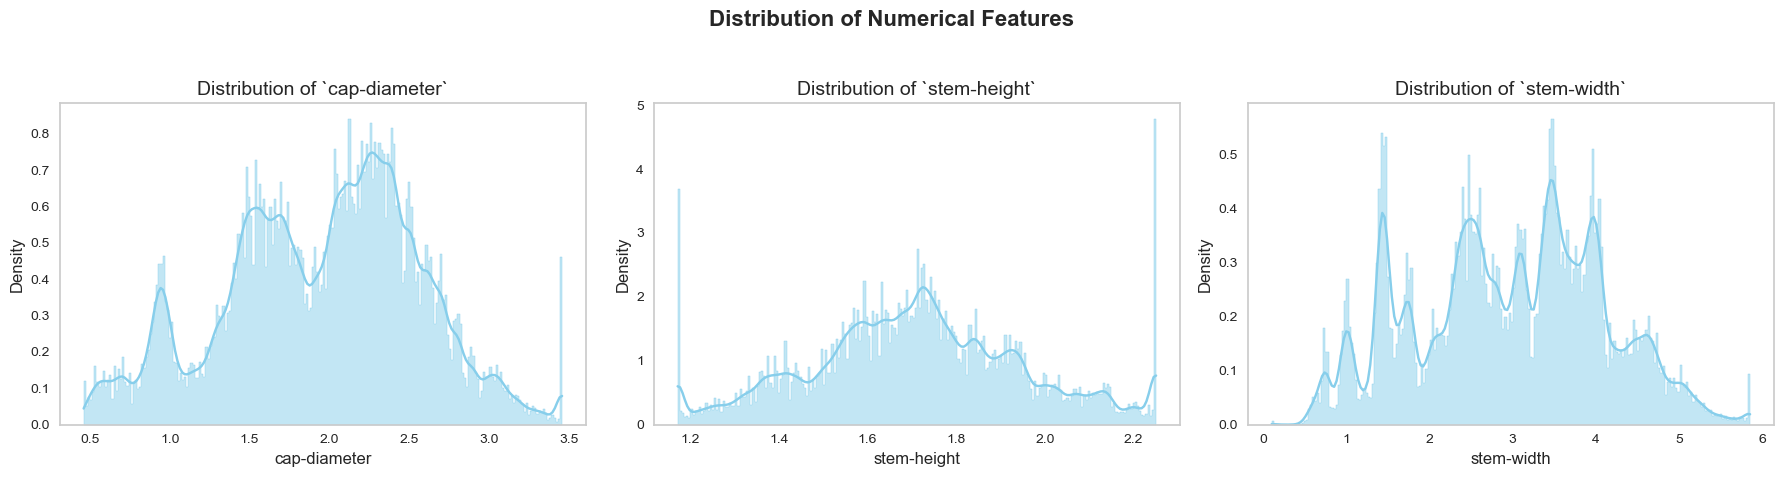

In [20]:
#(3) Draw histogram of `test`
draw_hist(df=test.loc[:, num_cols])

#### 03.3. **ENCODE CATEGORICLA COLUMNS**

##### 03.3.1. **ENCODE FEATRUE COLUMNS**

In [21]:
#(1) Encoding feature columns
CON = (cat_cols != 'class')
cat_cols_train = cat_cols[CON]
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#(2) Fit and transform features
train.loc[:, cat_cols_train] = ordinal_encoder.fit_transform(X=train.loc[:, cat_cols_train].astype(dtype='str'))
test.loc[:, cat_cols_train] = ordinal_encoder.transform(X=test.loc[:, cat_cols_train].astype(dtype='str'))

#(3) Change data type
train['id'] = train['id'].astype(dtype=pd.Int64Dtype())
train[cat_cols_train] = train[cat_cols_train].astype(dtype='int')
test[cat_cols_train] = test[cat_cols_train].astype(dtype='int')

##### 03.3.2. **ENCODE TARGET COLUMN**

In [22]:
#(1) Encoding target column
label_encoder = LabelEncoder()

#(2) Fit and transform target column
train.loc[:, 'class'] = label_encoder.fit_transform(y=train.loc[:, 'class'])

#### 03.4. **CHECK DATASETS**

In [23]:
#(1) Print `train`
train

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,0,2.4571,5,16,18,5,0,2,20,...,19,19,20,17,18,4,5,19,3,0
1,1,1,1.8030,21,7,13,5,0,2,12,...,19,22,13,17,18,16,23,19,3,3
2,2,0,2.2152,5,16,1,5,21,2,20,...,19,16,12,17,18,4,5,19,10,3
3,3,0,1.6681,5,22,6,5,16,16,6,...,19,19,20,17,18,4,5,19,3,2
4,4,0,2.0475,21,10,20,5,3,16,20,...,19,19,20,17,18,4,5,19,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177863,1558472,1,0.7990,16,16,22,5,5,5,5,...,19,19,22,17,18,4,5,19,3,0
3177864,1558472,1,0.8416,5,16,22,5,5,5,5,...,19,19,22,17,18,4,5,19,3,0
3177865,1558472,1,0.8416,16,16,22,5,5,5,5,...,19,19,22,17,18,4,5,19,3,2
3177866,1558472,1,0.8276,5,16,22,5,5,5,5,...,19,19,22,17,18,4,5,19,3,2


In [24]:
#(2) Print `test`
test

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,2.4380,21,19,12,16,19,16,20,2.1386,...,1,19,20,16,19,16,6,19,3,0
1,3116946,2.2095,13,17,13,5,19,2,22,1.1717,...,19,19,12,17,18,4,5,19,3,0
2,3116947,1.1381,1,6,12,5,19,2,12,1.7437,...,19,19,12,17,18,4,5,19,3,1
3,3116948,1.5713,21,17,12,5,16,2,12,1.5997,...,19,19,20,17,11,16,23,19,3,2
4,3116949,2.0992,21,7,22,5,14,16,22,1.8009,...,19,19,22,17,20,16,19,19,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077959,5194904,0.6442,21,6,20,5,0,3,20,1.1984,...,19,19,4,17,18,4,5,19,3,2
2077960,5194905,1.4818,21,16,20,5,3,2,20,1.2031,...,19,19,20,17,18,4,5,19,6,0
2077961,5194906,2.0275,21,4,4,5,0,16,20,1.7416,...,19,19,22,17,19,16,23,19,3,0
2077962,5194907,1.9039,1,6,12,5,0,3,6,1.7240,...,19,16,6,17,18,4,5,19,3,0


<b></b>

## 04. **BUILD MODELS BY `PYCARET`**

📔 **[DOCUMENT](https://pycaret.org)**

#### 04.1. **SET UP**

- `id` $ \rightarrow{} $ 삭제 (index)

- `stem-root`, `veil-type`, `veil-color`, `spore-print-color` $ \, \rightarrow{} $ 삭제 (결측값 비율 $ 80 \% $ 이상인 열)

In [25]:
pycrt_env = pycrt_clf.setup(
    data=train, 
    ignore_features=['id', 'veil-type', 'spore-print-color', 'stem-root', 'spore-print_color'],
    target='class', 
    train_size=0.9,
    use_gpu=False, 
    system_log=False,
    log_experiment=False,
    n_jobs=(os.cpu_count()-2),
    session_id=seed_num,
)

,Description,Value
0,Session id,2024
1,Target,class
2,Target type,Binary
3,Original data shape,"(3177868, 22)"
4,Transformed data shape,"(3177868, 18)"
5,Transformed train set shape,"(2860081, 18)"
6,Transformed test set shape,"(317787, 18)"
7,Ignore features,5
8,Numeric features,17
9,Preprocess,True


#### 04.2. **CHECK MODELS AND METRICS**

In [26]:
#(1) Print available models
pycrt_clf.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [27]:
#(2) Print available metrics
pycrt_clf.get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x1680468c0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x168046c20>,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x168046e60>,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False


#### 04.3. **COMPARE MODELS**

In [41]:
#(1) Compare models
compare_models = pycrt_clf.compare_models(
    # exclude=['svm', 'rbfsvm', 'nb', 'mlp', 'lda'], 
    n_select=5, 
    sort='mcc'
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9921,0.9961,0.9918,0.9937,0.9927,0.9840,0.9840,57.7040
et,Extra Trees Classifier,0.9916,0.9958,0.9914,0.9933,0.9923,0.9831,0.9831,48.7210
catboost,CatBoost Classifier,0.9913,0.9969,0.9909,0.9931,0.9920,0.9824,0.9824,63.9510
xgboost,Extreme Gradient Boosting,0.9911,0.9968,0.9906,0.9931,0.9919,0.9821,0.9821,2.4780
knn,K Neighbors Classifier,0.9897,0.9934,0.9896,0.9917,0.9906,0.9793,0.9793,405.9740
lightgbm,Light Gradient Boosting Machine,0.9884,0.9962,0.9875,0.9913,0.9894,0.9766,0.9766,3.7430
dt,Decision Tree Classifier,0.9828,0.9826,0.9844,0.9841,0.9843,0.9653,0.9653,3.4490
gbc,Gradient Boosting Classifier,0.9210,0.9750,0.9310,0.9251,0.9280,0.8404,0.8404,55.0460
ada,Ada Boost Classifier,0.7965,0.8820,0.8206,0.8101,0.8153,0.5888,0.5889,10.5310
qda,Quadratic Discriminant Analysis,0.6742,0.8068,0.5133,0.8254,0.6330,0.3676,0.4014,0.8750


In [42]:
#(2) Print best 5 models
print('>> Best 5 Model : ')
for i in np.arange(stop=5) : 
    print(f'[{i}] {type(compare_models[i]).__name__}')

>> Best 5 Model : 
[0] RandomForestClassifier
[1] ExtraTreesClassifier
[2] CatBoostClassifier
[3] XGBClassifier
[4] KNeighborsClassifier


#### 04.4. **TUNE MODELS**

##### 04.1. **TUNE `RANDOM FOREST`**

In [43]:
#(1) Create `rf`
rf = pycrt_clf.create_model(estimator='rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9921,0.9960,0.9916,0.9939,0.9928,0.9841,0.9841
1,0.9919,0.9960,0.9917,0.9936,0.9926,0.9837,0.9837
2,0.9921,0.9962,0.9920,0.9936,0.9928,0.9841,0.9841
3,0.9922,0.9962,0.9921,0.9937,0.9929,0.9843,0.9843
4,0.9922,0.9961,0.9920,0.9937,0.9929,0.9843,0.9843
5,0.9918,0.9959,0.9915,0.9934,0.9925,0.9834,0.9834
6,0.9920,0.9960,0.9918,0.9935,0.9927,0.9838,0.9838
7,0.9918,0.9958,0.9915,0.9935,0.9925,0.9835,0.9835
8,0.9921,0.9960,0.9918,0.9937,0.9928,0.9840,0.9840


In [44]:
#(2) Tune `rf`
rf_tuned = pycrt_clf.tune_model(
    estimator=rf, 
    optimize='mcc',
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=100,
    early_stopping=True,
    early_stopping_max_iters=10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9770,0.9944,0.9703,0.9875,0.9788,0.9537,0.9539
1,0.9756,0.9944,0.9680,0.9871,0.9775,0.9508,0.9510
2,0.9759,0.9946,0.9681,0.9877,0.9778,0.9515,0.9517
3,0.9764,0.9945,0.9697,0.9869,0.9782,0.9524,0.9526
4,0.9764,0.9946,0.9689,0.9877,0.9782,0.9524,0.9526
5,0.9769,0.9945,0.9704,0.9871,0.9787,0.9534,0.9536
6,0.9783,0.9946,0.9731,0.9871,0.9800,0.9563,0.9564
7,0.9761,0.9942,0.9694,0.9867,0.9780,0.9519,0.9521
8,0.9746,0.9944,0.9659,0.9874,0.9765,0.9489,0.9491


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [71]:
#(3) Save `rf`
try : 
    pycrt_clf.save_model(model=rf, model_name=f'{os.getcwd()}/../temp/{compet_nm}_rf', model_only=True, verbose=True)
    pycrt_clf.save_model(model=rf_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_rf_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved
Model Successfully Saved


##### 04.2. **TUNE `EXTRA TREE`**

In [46]:
#(1) Create `et`
et = pycrt_clf.create_model(estimator='et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9916,0.9958,0.9912,0.9935,0.9923,0.9831,0.9831
1,0.9916,0.9958,0.9914,0.9932,0.9923,0.9830,0.9831
2,0.9917,0.9959,0.9914,0.9934,0.9924,0.9833,0.9833
3,0.9917,0.9960,0.9916,0.9933,0.9924,0.9833,0.9833
4,0.9918,0.9958,0.9918,0.9933,0.9925,0.9835,0.9835
5,0.9914,0.9956,0.9910,0.9932,0.9921,0.9826,0.9826
6,0.9915,0.9957,0.9914,0.9931,0.9923,0.9829,0.9829
7,0.9914,0.9956,0.9911,0.9932,0.9922,0.9827,0.9827
8,0.9914,0.9957,0.9911,0.9932,0.9921,0.9827,0.9827


In [63]:
#(2) Tune `et`
et_tuned = pycrt_clf.tune_model(
    estimator=et, 
    optimize='mcc', 
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=50,
    early_stopping=True,
    early_stopping_max_iters=10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9846,0.9954,0.9796,0.9922,0.9859,0.9690,0.9691
1,0.9836,0.9954,0.9783,0.9916,0.9849,0.9670,0.9671
2,0.9836,0.9956,0.9784,0.9915,0.9849,0.9670,0.9671
3,0.9847,0.9956,0.9800,0.9920,0.9860,0.9692,0.9693
4,0.9847,0.9956,0.9803,0.9916,0.9859,0.9691,0.9692
5,0.9846,0.9955,0.9802,0.9915,0.9858,0.9689,0.9689
6,0.9845,0.9955,0.9798,0.9918,0.9857,0.9687,0.9688
7,0.9843,0.9954,0.9799,0.9914,0.9856,0.9684,0.9685
8,0.9849,0.9956,0.9801,0.9921,0.9861,0.9695,0.9696


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [70]:
#(3) Save `et`
try :
    pycrt_clf.save_model(model=et, model_name=f'{os.getcwd()}/../temp/{compet_nm}_et', model_only=True, verbose=True)
    pycrt_clf.save_model(model=et_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_et_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved
Model Successfully Saved


##### 04.3. **TUNE `CATBOOST`**

In [48]:
#(1) Create `catboost`
catboost = pycrt_clf.create_model(estimator='catboost', allow_writing_files=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9912,0.9969,0.9906,0.9932,0.9919,0.9822,0.9822
1,0.9912,0.9969,0.9910,0.9929,0.9920,0.9823,0.9823
2,0.9912,0.9969,0.9909,0.9929,0.9919,0.9822,0.9822
3,0.9914,0.9970,0.9912,0.9931,0.9922,0.9827,0.9827
4,0.9915,0.9968,0.9914,0.9932,0.9923,0.9829,0.9829
5,0.9911,0.9968,0.9907,0.9930,0.9918,0.9820,0.9820
6,0.9913,0.9969,0.9909,0.9931,0.9920,0.9824,0.9824
7,0.9912,0.9968,0.9907,0.9932,0.9920,0.9823,0.9823
8,0.9913,0.9969,0.9907,0.9934,0.9921,0.9825,0.9825


In [29]:
#(2) Tune `catboost`
catboost_tuned = pycrt_clf.tune_model(
    estimator=catboost, 
    optimize='mcc', 
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=50,
    early_stopping=True,
    early_stopping_max_iters=10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9917,0.9971,0.9914,0.9935,0.9924,0.9833,0.9833
1,0.9916,0.9971,0.9915,0.9931,0.9923,0.9831,0.9831
2,0.9918,0.9972,0.9919,0.9932,0.9925,0.9835,0.9835
3,0.9920,0.9972,0.9918,0.9935,0.9926,0.9838,0.9838
4,0.9918,0.9971,0.9918,0.9933,0.9925,0.9835,0.9835
5,0.9914,0.9970,0.9912,0.9932,0.9922,0.9827,0.9827
6,0.9916,0.9970,0.9915,0.9933,0.9924,0.9831,0.9831
7,0.9915,0.9970,0.9912,0.9932,0.9922,0.9828,0.9828
8,0.9917,0.9971,0.9915,0.9934,0.9924,0.9833,0.9833


In [30]:
#(3) Save `catboost`
try :
    pycrt_clf.save_model(model=catboost, model_name=f'{os.getcwd()}/../temp/{compet_nm}_catboost', model_only=True, verbose=True)
    pycrt_clf.save_model(model=catboost_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_catboost_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved
Model Successfully Saved


##### 04.4. **TUNE `XGBOOST`**

In [50]:
#(1) Create `xgboost`
xgboost = pycrt_clf.create_model(estimator='xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9911,0.9968,0.9905,0.9933,0.9919,0.9821,0.9821
1,0.9910,0.9969,0.9904,0.9931,0.9918,0.9818,0.9818
2,0.9911,0.9969,0.9906,0.9930,0.9918,0.9820,0.9820
3,0.9914,0.9970,0.9910,0.9933,0.9922,0.9827,0.9827
4,0.9912,0.9968,0.9909,0.9931,0.9920,0.9823,0.9823
5,0.9908,0.9967,0.9902,0.9930,0.9916,0.9815,0.9815
6,0.9910,0.9968,0.9906,0.9930,0.9918,0.9819,0.9819
7,0.9910,0.9968,0.9904,0.9931,0.9918,0.9818,0.9818
8,0.9911,0.9967,0.9905,0.9932,0.9919,0.9820,0.9820


In [62]:
#(2) Tune `xgboost`
xgboost_tuned = pycrt_clf.tune_model(
    estimator=xgboost, 
    optimize='mcc',
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=50,
    early_stopping=True,
    early_stopping_max_iters=10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9916,0.9970,0.9925,0.9921,0.9923,0.9830,0.9830
1,0.9915,0.9969,0.9926,0.9918,0.9922,0.9828,0.9828
2,0.9917,0.9970,0.9929,0.9919,0.9924,0.9832,0.9832
3,0.9917,0.9970,0.9928,0.9920,0.9924,0.9832,0.9832
4,0.9915,0.9968,0.9928,0.9917,0.9923,0.9829,0.9829
5,0.9912,0.9968,0.9923,0.9917,0.9920,0.9822,0.9822
6,0.9915,0.9968,0.9926,0.9918,0.9922,0.9828,0.9828
7,0.9913,0.9968,0.9923,0.9918,0.9921,0.9825,0.9825
8,0.9917,0.9968,0.9927,0.9921,0.9924,0.9831,0.9831


In [69]:
#(3) Save `xgboost`
try :
    pycrt_clf.save_model(model=xgboost, model_name=f'{os.getcwd()}/../temp/{compet_nm}_xgboost', model_only=True, verbose=True)
    pycrt_clf.save_model(model=xgboost_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_xgboost_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved
Model Successfully Saved


##### 04.5. **TUNE `KNN`**

In [52]:
#(1) Create `knn`
knn = pycrt_clf.create_model(estimator='knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9897,0.9933,0.9895,0.9918,0.9906,0.9793,0.9793
1,0.9897,0.9934,0.9894,0.9918,0.9906,0.9792,0.9792
2,0.9897,0.9936,0.9896,0.9916,0.9906,0.9793,0.9793
3,0.9900,0.9936,0.9899,0.9917,0.9908,0.9798,0.9798
4,0.9898,0.9933,0.9898,0.9917,0.9907,0.9795,0.9795
5,0.9893,0.9931,0.9892,0.9913,0.9902,0.9784,0.9785
6,0.9896,0.9933,0.9895,0.9915,0.9905,0.9790,0.9790
7,0.9896,0.9931,0.9896,0.9914,0.9905,0.9790,0.9790
8,0.9898,0.9934,0.9895,0.9919,0.9907,0.9795,0.9795


In [67]:
#(2) Tune `knn`
# knn_tuned = pycrt_clf.tune_model(
#     estimator=knn, 
#     optimize='mcc', 
#     search_library='optuna',
#     search_algorithm='tpe',
#     n_iter=50,
#     early_stopping=True,
#     early_stopping_max_iters=10
# )

In [77]:
#(3) Save `knn`
try :
    pycrt_clf.save_model(model=knn, model_name=f'{os.getcwd()}/../temp/{compet_nm}_knn', model_only=True, verbose=True)
    pycrt_clf.save_model(model=knn_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_knn_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved


##### 04.6. **TUNE `LIGHTGBM`**

In [54]:
#(1) Create `lightgbm`
lightgbm = pycrt_clf.create_model(estimator='lightgbm', verbosity=-1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9884,0.9960,0.9875,0.9912,0.9894,0.9765,0.9766
1,0.9883,0.9963,0.9872,0.9913,0.9893,0.9764,0.9764
2,0.9884,0.9963,0.9876,0.9912,0.9894,0.9766,0.9766
3,0.9885,0.9962,0.9872,0.9916,0.9894,0.9767,0.9767
4,0.9886,0.9961,0.9879,0.9912,0.9896,0.9770,0.9770
5,0.9882,0.9961,0.9873,0.9912,0.9892,0.9763,0.9763
6,0.9884,0.9962,0.9874,0.9912,0.9893,0.9765,0.9765
7,0.9885,0.9961,0.9875,0.9915,0.9895,0.9769,0.9769
8,0.9885,0.9961,0.9874,0.9914,0.9894,0.9767,0.9767


In [55]:
#(2) Tune `lightgbm`
lightgbm_tuned = pycrt_clf.tune_model(
    estimator=lightgbm, 
    optimize='mcc', 
    search_library='optuna',
    search_algorithm='tpe',
    n_iter=50,
    early_stopping=True,
    early_stopping_max_iters=10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9922,0.9972,0.9918,0.9940,0.9929,0.9844,0.9844
1,0.9923,0.9972,0.9920,0.9939,0.9929,0.9844,0.9844
2,0.9924,0.9973,0.9922,0.9938,0.9930,0.9846,0.9846
3,0.9925,0.9974,0.9923,0.9940,0.9931,0.9849,0.9849
4,0.9925,0.9972,0.9923,0.9939,0.9931,0.9849,0.9849
5,0.9920,0.9971,0.9918,0.9936,0.9927,0.9839,0.9839
6,0.9923,0.9972,0.9920,0.9940,0.9930,0.9845,0.9845
7,0.9921,0.9972,0.9919,0.9937,0.9928,0.9840,0.9840
8,0.9923,0.9972,0.9919,0.9940,0.9930,0.9845,0.9845


In [76]:
#(3) Save `lightgbm`
try :
    pycrt_clf.save_model(model=lightgbm, model_name=f'{os.getcwd()}/../temp/{compet_nm}_lightgbm', model_only=True, verbose=True)
    pycrt_clf.save_model(model=lightgbm_tuned, model_name=f'{os.getcwd()}/../temp/{compet_nm}_lightgbm_tuned', model_only=True, verbose=True)
except :
    pass

Model Successfully Saved
Model Successfully Saved


#### 04.4. **ENSEMBLE OF ENSEMBLE**

##### 04.1. **FIND BEST MODELS**

In [26]:
#(1) Define name of best models
best_models_nm = [
    'rf', 'et', 'catboost_tuned', 'xgboost_tuned', 'knn', 'lightgbm_tuned'
]

#(2) Road models (if need)
for model_nm in best_models_nm :
    try :
        globals()[f'{model_nm}'] = pycrt_clf.load_model(model_name=f'../temp/{compet_nm}_{model_nm}', verbose=False)
        print(f'>> Load done. Model name is "{model_nm}".')
    except : 
        print(f'>> Load Fail. Model name is "{model_nm}".')

In [34]:
#(3) Define `best_models`
best_models = [
    rf, et, catboost_tuned, xgboost_tuned, knn, lightgbm_tuned
]

#(4) Print `best_models`
best_models

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='sqrt',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        monotonic_cst=None, n_estimators=100, n_jobs=-1,
                        oob_score=False, random_state=2024, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='sqrt',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      monotonic_cst=None, n_estimators=100, n_jobs=-1,
                      oob_s

##### 04.2. **SOFT VOTING**

- 여러 모델의 예측값($ \hat{y} $)의 확률을 평균 처리하여 사용

In [32]:
#(1) Blend models
blended_models = pycrt_clf.blend_models(
    estimator_list=best_models,
    method='soft',
    optimize='mcc'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9923,0.9971,0.9920,0.9939,0.9930,0.9845,0.9845
1,0.9922,0.9970,0.9921,0.9936,0.9929,0.9843,0.9843
2,0.9923,0.9972,0.9923,0.9937,0.9930,0.9845,0.9845
3,0.9924,0.9972,0.9924,0.9937,0.9931,0.9847,0.9847
4,0.9924,0.9971,0.9924,0.9937,0.9931,0.9847,0.9847
5,0.9920,0.9969,0.9919,0.9934,0.9927,0.9838,0.9838
6,0.9922,0.9970,0.9921,0.9936,0.9929,0.9843,0.9843
7,0.9921,0.9970,0.9919,0.9936,0.9928,0.9841,0.9841
8,0.9923,0.9970,0.9921,0.9938,0.9930,0.9844,0.9844


In [ ]:
#(2)
blended_models

##### 04.3. **STACKING**

- 여러 모델의 예측값을 새로운 입력값으로 사용하고 새로운(메타) 모델을 이용하여 새로 예측을 수행

In [35]:
#(1) Stack models
stacked_models = pycrt_clf.stack_models(
    estimator_list=best_models,
    optimize='mcc'
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9924,0.9971,0.9922,0.9938,0.9930,0.9846,0.9846
1,0.9923,0.9970,0.9922,0.9938,0.9930,0.9845,0.9845
2,0.9924,0.9972,0.9924,0.9937,0.9931,0.9847,0.9847
3,0.9925,0.9972,0.9925,0.9938,0.9931,0.9849,0.9849
4,0.9925,0.9970,0.9925,0.9938,0.9932,0.9849,0.9849
5,0.9921,0.9970,0.9921,0.9934,0.9928,0.9840,0.9840
6,0.9923,0.9971,0.9924,0.9936,0.9930,0.9845,0.9845
7,0.9921,0.9970,0.9921,0.9935,0.9928,0.9841,0.9841
8,0.9924,0.9970,0.9922,0.9939,0.9930,0.9847,0.9847


In [ ]:
#(2)
stacked_models

#### 04.5. **FINALIZE MODELS**

In [36]:
finalized_models = pycrt_clf.finalize_model(estimator=stacked_models)

<b></b>

## 05. **PREDICT**

#### 05.1. **PREDICT TARGET**

In [43]:
#(1) Make `pred`
pred = pycrt_clf.predict_model(estimator=finalized_models, data=test)
pred.loc[:, 'class'] = label_encoder.inverse_transform(y=pred.loc[:, 'prediction_label'])
pred = relocate_col(df=pred, tar_col='prediction_score', std_col=pred.columns[-1], how='after')

#(2) Print `pred`
pred.loc[:, ['id', 'class', 'prediction_score']]

#### 05.2. **WRITE PREDICT**

In [38]:
#(1) Define `submission_nm`
submission_nm = 'blended_20240820'

#(2) Write `pred`
pred.loc[:, ['id', 'class']].to_csv(
    path_or_buf=f'../output/{compet_nm}_submission_{submission_nm}.csv',
    index=False
)

<b></b>

## 06. **END OF PROCESS**

In [39]:
try :
    os.remove(path='logs.log')
    shutil.rmtree(path='catboost_info')
except :
    pass